> Transfer Learning

VGG 16

VGG16 was selected as the pre-trained model for transfer learning because of its strong performance in image classification tasks and its ability to generalize well to new datasets, including fish classification. VGG16 remains a popular choice for transfer learning due to its strong low-level feature extraction and simple\Reliable architecture.

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))


In [ ]:
# IMPORTS
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# -------------------------------
# Paths
# -------------------------------
dataset_dir = r"C:\Users\96650\Downloads\archive (4)\fish_image"
base_output_dir = r"C:\Users\96650\Downloads\archive (4)\fish_split"

train_dir = os.path.join(base_output_dir, "train")
val_dir = os.path.join(base_output_dir, "val")
test_dir = os.path.join(base_output_dir, "test")

# Create output folders if not exist
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# -------------------------------
# Split dataset into train/val/test
# -------------------------------
classes = os.listdir(dataset_dir)

for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.30, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.50, random_state=42)

    # Create class subfolders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Copy images
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, cls))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, cls))

    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, cls))

print("Dataset successfully split into Train / Val / Test folders!")


# -------------------------------
# Image Data Generators
# -------------------------------

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)


Dataset successfully split into Train / Val / Test folders!
Found 19406 images belonging to 23 classes.
Found 4158 images belonging to 23 classes.
Found 4167 images belonging to 23 classes.
Number of classes: 23


In [4]:

# LOAD VGG16 WITHOUT TOP LAYERS

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze early layers (keep image features)
for layer in base_model.layers[:15]:
    layer.trainable = False

In [5]:

# ADD CUSTOM CLASSIFIER

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [7]:
from tensorflow.keras.optimizers import Adam
# COMPILE MODEL

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,572,055 (105.18 MB)

 Trainable params: 19,936,791 (76.05 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [8]:
# TRAIN MODEL

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


Epoch 1/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 3052s 5s/step - accuracy: 0.8834 - loss: 0.4204 - val_accuracy: 0.9372 - val_loss: 0.2150
Epoch 2/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 3327s 5s/step - accuracy: 0.9558 - loss: 0.1542 - val_accuracy: 0.9695 - val_loss: 0.1149
Epoch 3/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 3578s 6s/step - accuracy: 0.9699 - loss: 0.1048 - val_accuracy: 0.9721 - val_loss: 0.0904
Epoch 4/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 2786s 5s/step - accuracy: 0.9757 - loss: 0.0830 - val_accuracy: 0.9808 - val_loss: 0.0647
Epoch 5/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 3595s 6s/step - accuracy: 0.9794 - loss: 0.0722 - val_accuracy: 0.9810 - val_loss: 0.0713
Epoch 6/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 3387s 6s/step - accuracy: 0.9824 - loss: 0.0605 - val_accuracy: 0.9822 - val_loss: 0.0607
Epoch 7/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 2849s 5s/step - accuracy: 0.9843 - loss: 0.0533 - val_accuracy: 0.9841 - val_loss: 0.0542
Epoch 8/15
607/607 ━━━━━━━━━━━━━━━━━━━━ 8041s 13s/step - accuracy: 0.9845 - loss: 0.0528 -

In [9]:

# EVALUATE ON TEST SET

test_loss, test_acc = model.evaluate(test_generator)
print("\nTest Accuracy:", test_acc)




131/131 ━━━━━━━━━━━━━━━━━━━━ 573s 4s/step - accuracy: 0.9839 - loss: 0.0709

Test Accuracy: 0.9839212894439697


131/131 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step

Classification Report:
              precision    recall  f1-score   support

     fish_01       0.98      1.00      0.99      1817
     fish_02       0.98      1.00      0.99       403
     fish_03       1.00      0.96      0.98       539
     fish_04       1.00      1.00      1.00       608
     fish_05       0.99      1.00      1.00       381
     fish_06       1.00      0.69      0.82        29
     fish_07       0.97      1.00      0.99        68
     fish_08       0.93      0.79      0.85        33
     fish_09       1.00      0.86      0.93        37
     fish_10       1.00      1.00      1.00        45
     fish_11       0.92      0.80      0.86        15
     fish_12       0.88      0.91      0.89        23
     fish_13       1.00      1.00      1.00        28
     fish_14       0.92      0.79      0.85        14
     fish_15       1.00      1.00      1.00        12
     fish_16       0.97      1.00      0.98        31
     fish_17   

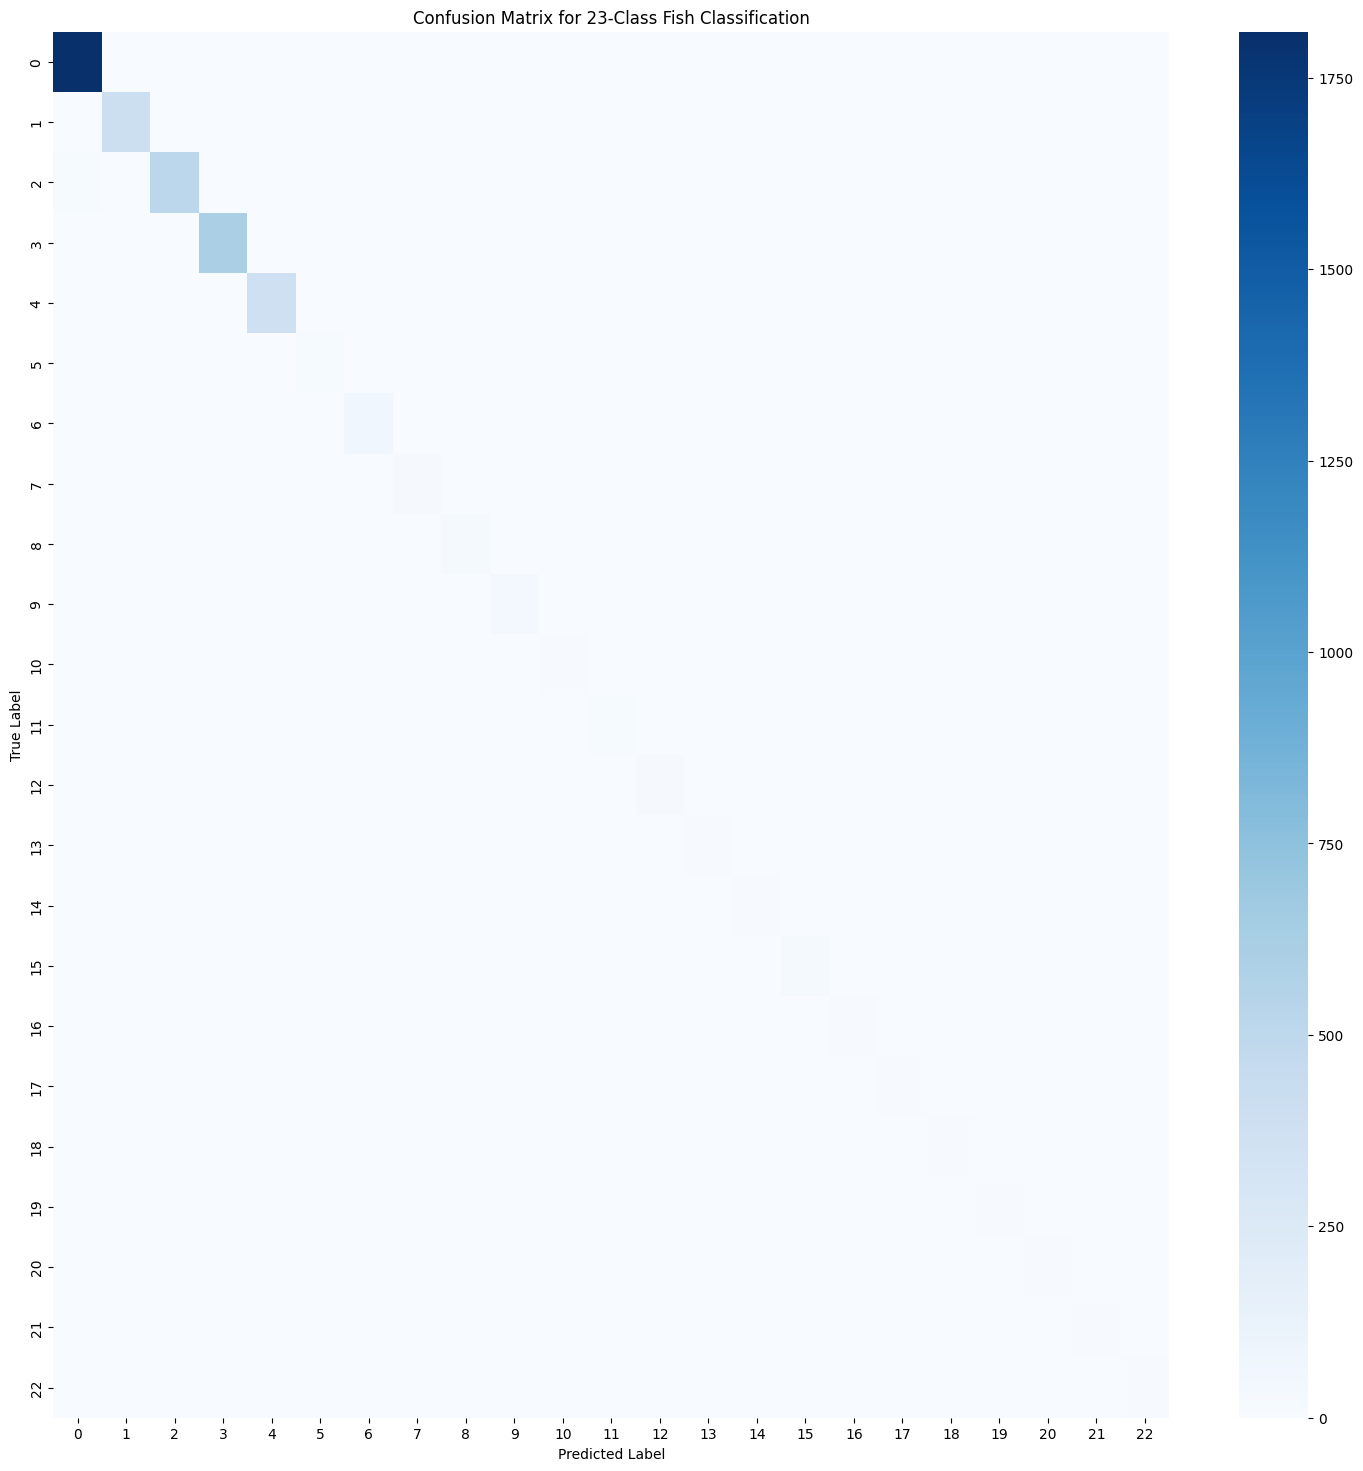

In [14]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# PREDICTIONS FOR METRICS

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


# CLASSIFICATION REPORT

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(18, 18))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix for 23-Class Fish Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# OPTIONAL UNFREEZE DEEP LAYERS FOR FINE-TUNING

fine_tune = False  

if fine_tune:
    for layer in base_model.layers[15:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_ft = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )


In [ ]:


# Folder to save results

save_dir = r"C:\Users\96650\Desktop\ذكاااء2\assig2 AI2\vgg16_single_run_results"
os.makedirs(save_dir, exist_ok=True)

# 1️. SAVE TRAINED MODEL
model.save(os.path.join(save_dir, "vgg16_model.h5"))
print("Model saved successfully!")


# 2️. SAVE CLASSIFICATION REPORT

report = classification_report(y_true, y_pred_classes, target_names=class_labels)

with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(report)

print("Classification report saved!")


# 3️. SAVE CONFUSION MATRIX IMAGE

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(18, 18))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix for 23-Class Fish Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.close()

print("Confusion matrix saved!")


# 4️. SAVE TRAINING CURVES (accuracy & loss)


plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.savefig(os.path.join(save_dir, "accuracy_curve.png"))
plt.close()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.savefig(os.path.join(save_dir, "loss_curve.png"))
plt.close()

print("Training curves saved!")


# 5️. SAVE TEST METRICS

with open(os.path.join(save_dir, "metrics.txt"), "w") as f:
    f.write(f"Test Accuracy: {test_acc}\n")
    f.write(f"Number of Classes: {num_classes}\n")

print("Metrics saved!")

print("\n✅ ALL RESULTS SAVED SUCCESSFULLY!")
print("Saved in:", save_dir)


Model saved successfully!
Classification report saved!
Confusion matrix saved!
Training curves saved!
Metrics saved!

✅ ALL RESULTS SAVED SUCCESSFULLY!
Saved in: C:\Users\96650\Desktop\ذكاااء2\assig2 AI2\vgg16_single_run_results
